In [12]:
from qiskit import QuantumCircuit, transpile
from qiskit.visualization import plot_histogram
from qiskit.quantum_info import Statevector
import numpy as np
from scipy.io.wavfile import read
import matplotlib.pyplot as plt
from qiskit.circuit.library import QFT
from qiskit_aer import AerSimulator, Aer, aer_simulator
from scipy.io.wavfile import read, write


In [13]:
n_qubits = 13

In [14]:
def load_and_normalize_audio(filename):
    """Load audio file in blocks of 2^n_qubits samples"""
    sample_rate, audio = read(filename)

    # Convert to mono if stereo
    if len(audio.shape) > 1:
        audio = audio[:, 0]
    
    target_samples = 2**n_qubits
    audio = audio[:target_samples]  

    norm_factor = np.linalg.norm(audio)
    normalized_audio = audio / norm_factor
    
    return sample_rate, normalized_audio, norm_factor, n_qubits

def prepare_quantum_state(normalized_audio):
    """Prepare a quantum state from normalized audio data."""
    qc = QuantumCircuit(n_qubits)

    # Initialize the quantum state with the normalized audio data
    qc.initialize(normalized_audio, range(n_qubits))

    return qc

In [15]:
def denoise_oracle(statevector, threshold=0.05):

    probabilities = np.abs(statevector.data) ** 2

    for i in range (0,2**n_qubits):
        if probabilities[i] < threshold:
            statevector.data[i] = 0
        else:
            print(i)
    
    norm_factor2 = np.linalg.norm(statevector.data)

    normalized_denoise = statevector.data/norm_factor2

    denoised_state = prepare_quantum_state(normalized_denoise)
    

    return denoised_state

In [16]:
audio_file = "noisy_audio.wav"

# Load and normalize audio data
sample_rate, normalized_audio, norm_factor, n_qubits = load_and_normalize_audio(audio_file)

qc = prepare_quantum_state(normalized_audio)

qc.append(QFT(n_qubits, do_swaps=True), range(n_qubits))


# Get state after QFT
state = Statevector(qc)  

# Apply oracle to denoise the signal
qc = qc.compose((denoise_oracle(state)))

# Inverse QFT to return to time domain
qc = qc.compose(QFT(n_qubits, do_swaps=True, inverse=True), range(n_qubits))

# "Measure" the statevector
backend = Aer.get_backend('statevector_simulator')
qc = transpile(qc, backend)

state = Statevector(qc)  

82
8110


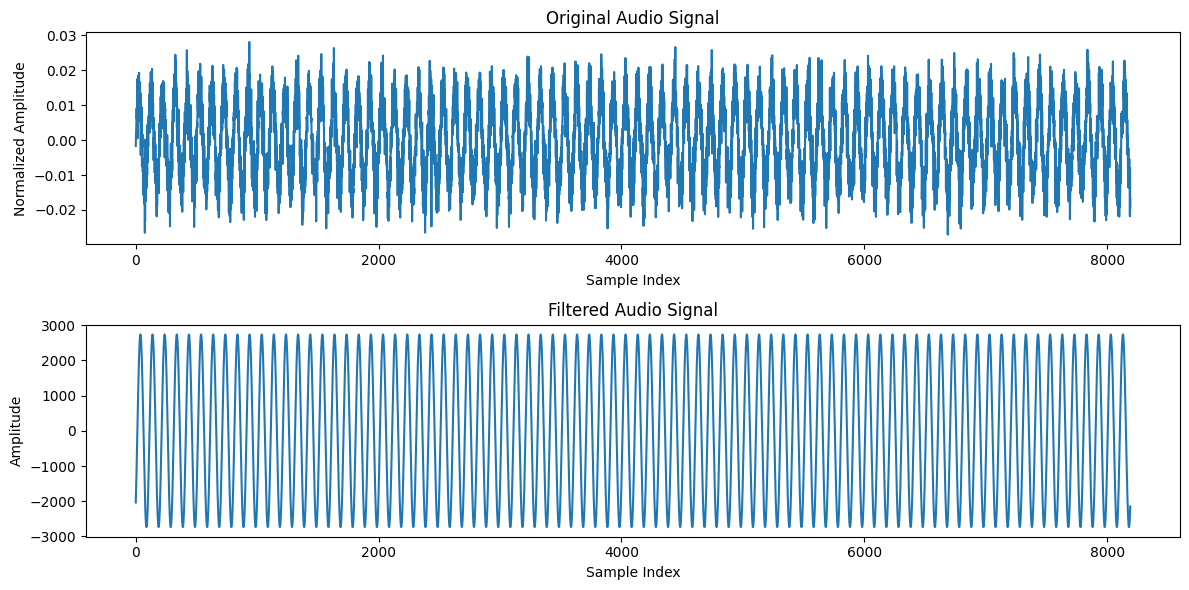

In [17]:
retrieved_audio = (state.data.real)

retrieved_audio = retrieved_audio * norm_factor  

plt.figure(figsize=(12, 6))

plt.subplot(2, 1, 1)
plt.plot(range(2**n_qubits), normalized_audio)
plt.title("Original Audio Signal")
plt.xlabel("Sample Index")
plt.ylabel("Normalized Amplitude")

plt.subplot(2, 1, 2)
plt.plot(range(2**n_qubits), retrieved_audio)
plt.title("Filtered Audio Signal")
plt.xlabel("Sample Index")
plt.ylabel("Amplitude")

plt.tight_layout()
plt.show()

In [18]:
filtered_audio = np.int16(retrieved_audio) 

output_filename = "quantum_filtered.wav"
write(output_filename, sample_rate, filtered_audio)